# Solvers

This notebook will focus on various least-squares and L1 solvers and show how an apparently ill-posed problem can be solved by adding additional (prior) information to the problem.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pylops
import scooby

from scipy.linalg import lstsq, toeplitz, cholesky
from scipy.sparse.linalg import lsqr
from pylops import LinearOperator
from pylops.utils import dottest

np.random.seed(0)

## Cost functions

To start we look at the difference in the cost functions used by L2 and L1 solvers

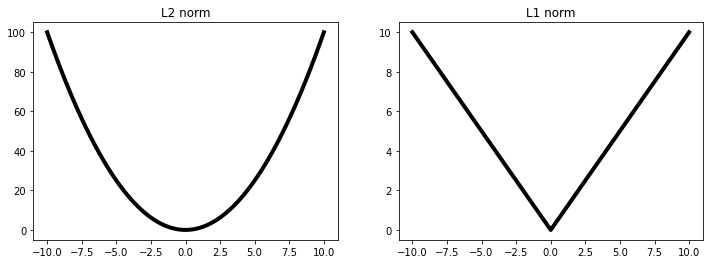

In [2]:
x = np.linspace(-10, 10, 101)

j_l2 = x ** 2
j_l1 = np.abs(x)

fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(x, j_l2, 'k', lw=4)
axs[0].set_title('L2 norm')
axs[1].plot(x, j_l1, 'k', lw=4)
axs[1].set_title('L1 norm');

## Problem definition

The problem that we are going to consider is generally referred to
as the *data reconstruction* problem and aims at reconstructing a regularly
sampled signal of size $M$ from $N$ randomly selected samples:

\begin{align}\mathbf{d} = \mathbf{R} \mathbf{m}\end{align}

where the restriction operator $\mathbf{R}$ that selects the $M$
elements from $\mathbf{m}$ at random locations is implemented using `pylops.Restriction`, and

\begin{align}\mathbf{d}= [d_1, d_2,...,d_N]^T, \qquad
    \mathbf{m}= [m_1, m_2,...,m_M]^T, \qquad\end{align}

with $M>>N$.

Let's first create the data in the frequency domain. The data is composed
by the superposition of 3 sinusoids with different frequencies. We then use the `pylops.FFT` operator to obtain the time domain version of the signal.

In [3]:
# input signal parameters
ifreqs = [41, 25, 66]
amps = [1., 1., 1.]
nt = 200
nfft = 2**11
dt = 0.004
t = np.arange(nt)*dt
f = np.fft.rfftfreq(nfft, dt)

# input signal in frequency domain
M = np.zeros(nfft//2+1, dtype='complex128')
M[ifreqs] = amps

# input signal in time domain
FFTop = pylops.signalprocessing.FFT(nt, nfft=nfft, real=True)
m = FFTop.H*M

We now define the locations at which the signal will be sampled, apply forward, adjoint and inverse

In [4]:
# sampling locations    
perc_subsampling = 0.2
ntsub = int(np.round(nt*perc_subsampling))
iava = np.sort(np.random.permutation(np.arange(nt))[:ntsub])

# create operator
Rop = pylops.Restriction(nt, iava, dtype='float64')

# create noise
sigma=1e-2
n = np.random.normal(0, sigma, nt)

# apply forward
d = Rop*m
dn = Rop*(m + n)
dmask = Rop.mask(m)
dnmask = Rop.mask(m + n)

# apply adjoint
madj = Rop.H * dn

# apply inverse
minv = Rop / dn

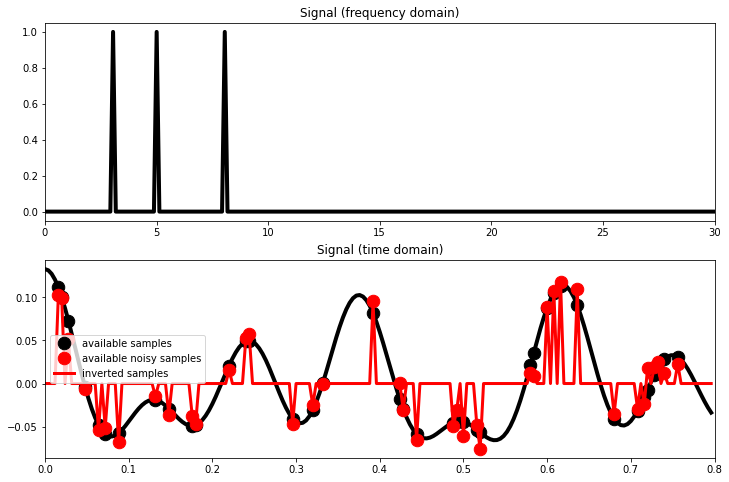

In [5]:
# Visualize
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(f, np.abs(M), 'k', lw=4)
axs[0].set_xlim(0, 30)
axs[0].set_title('Signal (frequency domain)')
axs[1].plot(t, m, 'k', lw=4)
axs[1].plot(t, dmask, '.k', ms=25, label='available samples')
axs[1].plot(t, dnmask, '.r', ms=25, label='available noisy samples')
axs[1].plot(t, minv, 'r', lw=3, label='inverted samples')
axs[1].legend()
axs[1].set_title('Signal (time domain)')
axs[1].set_xlim(0, 0.8);

We see that solving the problem without providing any additional (prior) information does not provide a satisfactory estimate of the original (finely sampled) signal

## Problem solution

### Regularized inversion

First of all we add a second term to the cost function imposing minimum second order derivative of the model. This is equivalent to minimizing the roughness of the reconstruction, leading to a smooth estimate:

$$
\begin{bmatrix}
            \mathbf{R}    \\
            \epsilon \nabla
\end{bmatrix} \mathbf{m} =
\begin{bmatrix}
    \mathbf{d}    \\
    \mathbf{0}
\end{bmatrix}
$$

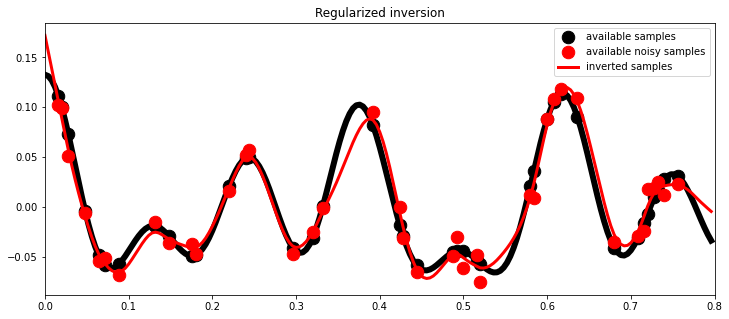

In [6]:
D2op = pylops.SecondDerivative(nt, dims=None, dtype='float64')
epsR = np.sqrt(1e1)
epsI = np.sqrt(1e-4)

mreg = \
    pylops.optimization.leastsquares.RegularizedInversion(Rop, [D2op], dn,
                                                          epsRs=[epsR],
                                                          returninfo=False,
                                                          **dict(iter_lim=100, damp=epsI))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, m, 'k', lw=6)
ax.plot(t, dmask, '.k', ms=25, label='available samples')
ax.plot(t, dnmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, mreg, 'r', lw=3, label='inverted samples')
ax.legend()
ax.set_title('Regularized inversion')
ax.set_xlim(0, 0.8);

### Bayesian inversion

Let's consider now the same problem, but we want to frame in a Bayesian context. We have two equivalent solutions:

$$\mathbf{m} = (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{R} + \mathbf{C}^{-1}_m)^{-1} (\mathbf{R}^T \mathbf{C}^{-1}_d \mathbf{d} + \mathbf{C}^{-1}_m \mathbf{m_0})$$

and  

$$\mathbf{m} = \mathbf{m_0} + \mathbf{C}_m \mathbf{R}^T (\mathbf{R} \mathbf{C}_m \mathbf{R}^T + \mathbf{C}_d)^{-1} (\mathbf{d} - \mathbf{R} \mathbf{m_0})$$

The first one can be easily written as a regularized problem:

$$
\begin{bmatrix}
            \mathbf{C}^{-1/2}_d \mathbf{R}    \\
            \mathbf{C}^{-1/2}_{m} \\
\end{bmatrix} \mathbf{m} =
\begin{bmatrix}
    \mathbf{C}^{-1/2}_d \mathbf{d}    \\
    \mathbf{C}^{-1/2}_{m} \mathbf{m}_0
\end{bmatrix}
$$

but it is difficult to implement because we would need to be able to 'model' the square-root inverse covariances.

On the other hand the first one can be easily implemented using linear operators, where:


$$\mathbf{C}_d = \sigma^2 \mathbf{I} \quad (\mathbf{C}^{-1/2}_d  = 1/\sigma \mathbf{I})$$,

$$\mathbf{C}_m = \mathbf{C}_m^{\sigma^{1/2}} \mathbf{C}_m^{\rho} \mathbf{C}_m^{\sigma^{1/2}} \quad (\mathbf{C}^{-1/2}_m  = (\mathbf{C}_m^{\sigma^{-1/2} })^T \mathbf{C}_m^{\rho^{-1/2}})$$,

$$\mathbf{m}_0 = m_0 \mathbf{I}$$

Here $\mathbf{C}_m^{\sigma^{1/2}} = \sigma_m \mathbf{I}$ and $\mathbf{C}_m^{\rho} = (\mathbf{C}_m^{\rho^{1/2}})^T \mathbf{C}_m^{\rho^{1/2}}$, where $\mathbf{C}_m^{\rho^{1/2}}$ is a convolutional matrix with a given correlation shape (e.g., exponentional).

Let's start by solving the problem with explicit matrices. First of all we deal with the model prior:

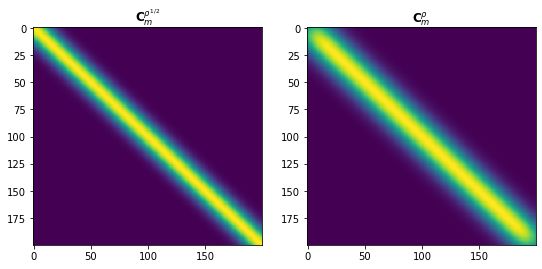

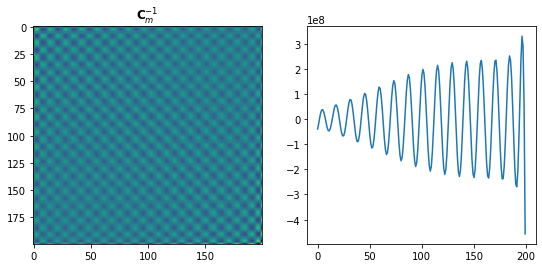

In [7]:
# Mean
m0 = 0.1 * np.ones_like(m)

# Correlation and covariance functions
corr_range = .1
sigma_m = 1e-2
corr_sqrt = np.exp(-3*(t)**2/corr_range**2)
Corr_sqrt = toeplitz(corr_sqrt)
Corr = np.dot(Corr_sqrt.T, Corr_sqrt)
Std = np.diag(sigma_m*np.ones(Corr.shape[0]))
Cm = np.dot(Std, np.dot(Corr, Std))

fig = plt.figure(figsize=(9, 4))
ax1 = plt.subplot(121)
ax1.imshow(Corr_sqrt, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{\rho^{1/2}}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.imshow(Corr, interpolation='nearest')
ax2.set_title(r"$\mathbf{C}_m^{\rho}$")
ax2.axis('tight')

# Inverse
Corr_sqrt_inv = np.linalg.pinv(Corr_sqrt, rcond=1e-10)
Corr_inv = np.linalg.pinv(Corr, rcond=1e-10)
Cm_inv = np.linalg.pinv(Cm, rcond=1e-10)

fig = plt.figure(figsize=(9, 4))
ax1 = plt.subplot(121)
ax1.imshow(Cm_inv, interpolation='nearest')
ax1.set_title(r"$\mathbf{C}_m^{-1}$")
ax1.axis('tight')
ax2 = plt.subplot(122)
ax2.plot(Cm_inv[nt//2]);

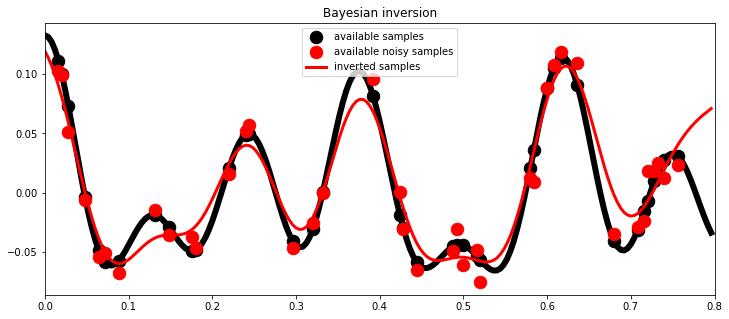

In [8]:
# Problem
R = np.zeros((ntsub, nt))
R[np.arange(ntsub), iava] = 1

# Data covariance
Cd = sigma**2 * np.eye(ntsub)

mbayes = \
    m0 + np.dot(Cm, np.dot(R.T, np.dot(np.linalg.inv(np.dot(R, np.dot(Cm, R.T)) + Cd), 
                                        dn - np.dot(R, m0))))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, m, 'k', lw=6)
ax.plot(t, dmask, '.k', ms=25, label='available samples')
ax.plot(t, dnmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, mbayes, 'r', lw=3, label='inverted samples')
ax.legend()
ax.set_title('Bayesian inversion')
ax.set_xlim(0, 0.8);

Since ideally we do not want to create those matrices explicitely, we can repeat the same exercise with equivalent linear operators

In [9]:
Cm_op = \
    (sigma_m * pylops.Identity(nt)) * \
    pylops.signalprocessing.Convolve1D(nt, Corr[nt//2, nt//2-50:nt//2+51], offset=50) * \
    (sigma_m * pylops.Identity(nt))

Cd_op = (sigma**2) * pylops.Identity(ntsub)

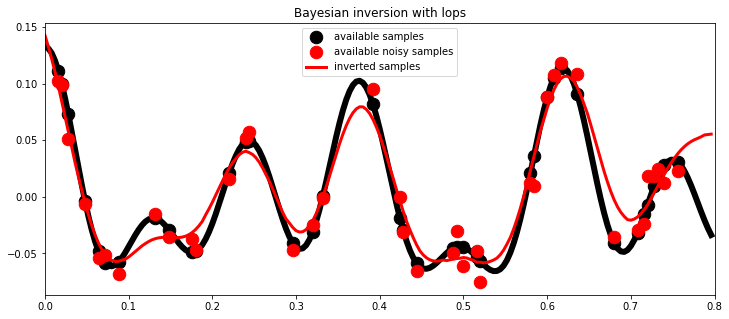

In [10]:
mbayes = \
    m0 + Cm_op * Rop.H * (lsqr(Rop * Cm_op * Rop.H + Cd_op, dn - Rop * m0, iter_lim=100, damp=1e-5)[0])

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, m, 'k', lw=6)
ax.plot(t, dmask, '.k', ms=25, label='available samples')
ax.plot(t, dnmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, mbayes, 'r', lw=3, label='inverted samples')
ax.set_title('Bayesian inversion with lops')
ax.legend()
ax.set_xlim(0, 0.8);

### Preconditioned inversion

Back to deterministic inversion, we add now a preconditioner imposing smoothness in the solution:

$$\mathbf{d} = \mathbf{R}  \mathbf{S} \mathbf{z}$$

where $\mathbf{m} = \mathbf{P} \mathbf{z}$

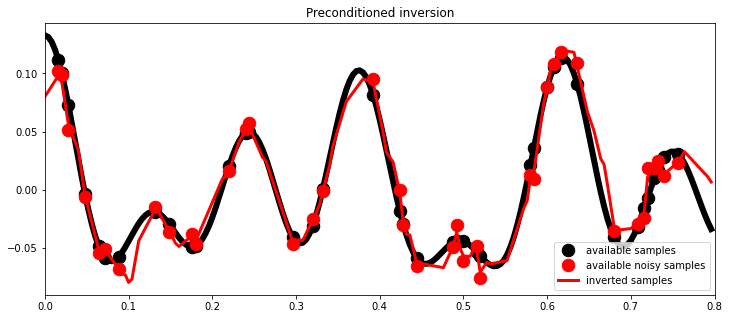

In [11]:
Sop  = pylops.basicoperators.Smoothing1D(nsmooth=21, dims=[nt], dtype='float64')

mprec = \
    pylops.optimization.leastsquares.PreconditionedInversion(Rop, Sop, dn, returninfo=False,
                                                             **dict(damp=np.sqrt(1e-3), iter_lim=100, show=0))

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, m, 'k', lw=6)
ax.plot(t, dmask, '.k', ms=25, label='available samples')
ax.plot(t, dnmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, mprec, 'r', lw=3, label='inverted samples')
ax.legend()
ax.set_title('Preconditioned inversion')
ax.set_xlim(0, 0.8);

### Sparse solver

To conclude we use a sparse solver. We assume knowledge about the modelling process: the input signal was created in the frequency domain as summation of three sinusoids. We can thus assume the signal Fourier representation will be sparse (i.e, just a few spikes at the correct frequencies). 

In mathematical terms, solving for a sparse model is equivalent to add a regularization terms that requires to minimize the $L_1$ norm of the model:

$$ ||\mathbf{p}||_1 \qquad subject \quad to \qquad  \mathbf{d} = \mathbf{R} \mathbf{S} \mathbf{z} $$ 

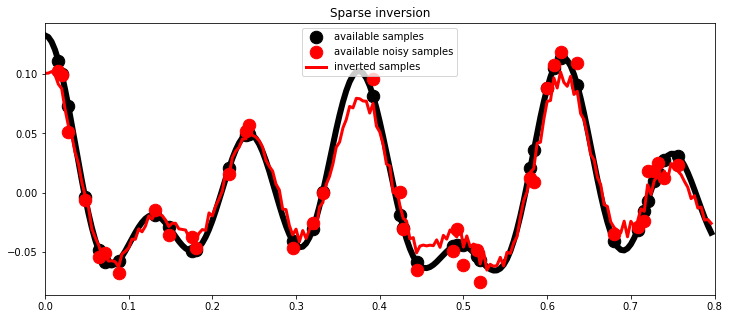

In [12]:
# sparse inversion
#mspgl1, zspgl1, info = pylops.optimization.sparsity.SPGL1(Rop, dn, FFTop, tau=3, iter_lim=100)
pfista = pylops.optimization.sparsity.FISTA(Rop * FFTop.T, dn, eps=5e-3, niter=100)[0]
mfista = np.real(FFTop.T * pfista)

# Visualize
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.plot(t, m, 'k', lw=6)
ax.plot(t, dmask, '.k', ms=25, label='available samples')
ax.plot(t, dnmask, '.r', ms=25, label='available noisy samples')
ax.plot(t, mfista, 'r', lw=3, label='inverted samples')
ax.legend()
ax.set_title('Sparse inversion')
ax.set_xlim(0, 0.8);

In [13]:
scooby.Report(core='pylops')

--------------------------------------------------------------------------------
  Date: Sat Mar 13 10:38:03 2021 +03

                OS : Darwin
            CPU(s) : 16
           Machine : x86_64
      Architecture : 64bit
       Environment : Jupyter

  Python 3.8.5 (default, Sep  4 2020, 02:22:02)  [Clang 10.0.0 ]

            pylops : 1.10.1.dev105+g3d28371
             numpy : 1.19.2
             scipy : 1.5.2
           IPython : 7.19.0
        matplotlib : 3.3.2
            scooby : 0.5.6

  Intel(R) Math Kernel Library Version 2019.0.4 Product Build 20190411 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------